# Image Captioning

In [1]:
import pandas as pd
!pip install tqdm
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import re
# text
import string
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


D0628 14:56:51.308736643      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0628 14:56:51.308762051      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0628 14:56:51.308766042      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0628 14:56:51.308769057      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0628 14:56:51.308771960      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0628 14:56:51.308775074      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0628 14:56:51.308785477      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0628 14:56:51.

In [2]:
# # connect to a TPU and instantiate a distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [3]:
# Read text data from txt file using pandas
text_data = pd.read_csv('/kaggle/input/flickr8k/captions.txt', sep='|')
# text_data.columns = ['image_id', 'caption']
text_data

image_name  caption_number  \
0      1000268201_693b08cb0e.jpg               0   
1      1000268201_693b08cb0e.jpg               1   
2      1000268201_693b08cb0e.jpg               2   
3      1000268201_693b08cb0e.jpg               3   
4      1000268201_693b08cb0e.jpg               4   
...                          ...             ...   
40450   997722733_0cb5439472.jpg               0   
40451   997722733_0cb5439472.jpg               1   
40452   997722733_0cb5439472.jpg               2   
40453   997722733_0cb5439472.jpg               3   
40454   997722733_0cb5439472.jpg               5   

                                            caption_text  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 3 columns]

In [4]:
# Separate the image name from the image id
# text_data['image_name'] = text_data['image_id'].apply(lambda x: x.split('#')[0])
# text_data['image_repeat'] = text_data['image_id'].apply(lambda x: x.split('#')[1])

text_data.rename(columns={"caption_number":"image_repeat","caption_text":"caption"},inplace=True)
text_data

image_name  image_repeat  \
0      1000268201_693b08cb0e.jpg             0   
1      1000268201_693b08cb0e.jpg             1   
2      1000268201_693b08cb0e.jpg             2   
3      1000268201_693b08cb0e.jpg             3   
4      1000268201_693b08cb0e.jpg             4   
...                          ...           ...   
40450   997722733_0cb5439472.jpg             0   
40451   997722733_0cb5439472.jpg             1   
40452   997722733_0cb5439472.jpg             2   
40453   997722733_0cb5439472.jpg             3   
40454   997722733_0cb5439472.jpg             5   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 3 columns]

In [5]:
# Drop rows with given index
text_data.drop(text_data[text_data['image_name']=="2258277193_586949ec62.jpg.1"].index, inplace=True)
text_data.reset_index(drop=True, inplace=True)

In [6]:
def preprocessing_text( line ):
    # lowercase all the english words
    line  = line.lower()
    # remove punctuation
    line = line.translate(str.maketrans('', '', string.punctuation))
    return line

print("Preprocessing Text")
text_data['caption'] = text_data['caption'].progress_apply( preprocessing_text )
# data.dropna( inplace=True )
# data.reset_index(drop=True, inplace=True)
text_data

Preprocessing Text


100%|██████████| 40455/40455 [00:00<00:00, 149418.39it/s]


image_name  image_repeat  \
0      1000268201_693b08cb0e.jpg             0   
1      1000268201_693b08cb0e.jpg             1   
2      1000268201_693b08cb0e.jpg             2   
3      1000268201_693b08cb0e.jpg             3   
4      1000268201_693b08cb0e.jpg             4   
...                          ...           ...   
40450   997722733_0cb5439472.jpg             0   
40451   997722733_0cb5439472.jpg             1   
40452   997722733_0cb5439472.jpg             2   
40453   997722733_0cb5439472.jpg             3   
40454   997722733_0cb5439472.jpg             5   

                                                 caption  
0      a child in a pink dress is climbing up a set o...  
1                   a girl going into a wooden building   
2        a little girl climbing into a wooden playhouse   
3      a little girl climbing the stairs to her playh...  
4      a little girl in a pink dress going into a woo...  
...                                                  ...  
40450           a man in a pink shirt climbs a rock face  
40451            a man is rock climbing high in the air   
40452  a person in a red shirt climbing up a rock fac...  
40453                     a rock climber in a red shirt   
40454  a rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [7]:
# Add start and end tokens into english sentences
text_data['caption'] = text_data['caption'].progress_apply( lambda x: 'START '+ x + ' END' )

# Tokenize the english sentences using Keras tokenizer
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer( lower=False , split=' ', char_level=False, oov_token="oovE",filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # num_words=num_words
tokenizer.fit_on_texts(text_data['caption'].values)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: ", vocab_size)

# Convert the english sentences into sequences
sequences = tokenizer.texts_to_sequences(text_data['caption'].values)
max_length = max([len(line) for line in sequences])

# padding sequence (max_length)
padded_sequences = []
for sequence in tqdm(sequences):
    if len(sequence) < max_length:
        sequence += [0] * (max_length - len(sequence))
    padded_sequences.append(sequence)

# print(tokenizer.word_index)
print(text_data['caption'][0])
print(sequences[0])
print(padded_sequences[0])

100%|██████████| 40455/40455 [00:00<00:00, 424363.74it/s]


Vocabulary Size:  8832


100%|██████████| 40455/40455 [00:00<00:00, 490553.72it/s]

START a child in a pink dress is climbing up a set of stairs in an entry way  END
[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 5224, 694, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 5224, 694, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
# remove the padding from the sequence
def remove_padding_from_sequence(sequence):
    return [word for word in sequence if word != 0]
    
# Print the sequence and compare with the original sentence using keras
n = 2
for j in range( n ):
    i = np.random.randint( text_data.shape[0] )
    print( i )
    print("Original Sentence ---> ", text_data["caption"][i])
    print("Sequence ---> ", padded_sequences[i])
    print(" Sequence into Sentence  ---> ", tokenizer.sequences_to_texts( [remove_padding_from_sequence(padded_sequences[i])] )) 
    print("---------------------   -  --------------------- \n ")


1992
Original Sentence --->  START a little girl highfives a yellow robot  END
Sequence --->  [3, 2, 41, 20, 4199, 2, 60, 2006, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Sequence into Sentence  --->  ['START a little girl highfives a yellow robot END']
---------------------   -  --------------------- 
 
25356
Original Sentence --->  START a black dog jumping and playing in the snow near a chain link fence  END
Sequence --->  [3, 2, 16, 10, 46, 9, 35, 5, 6, 45, 68, 2, 883, 1603, 174, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Sequence into Sentence  --->  ['START a black dog jumping and playing in the snow near a chain link fence END']
---------------------   -  --------------------- 
 


In [9]:
text_data['padded_sequences'] = padded_sequences
text_data

image_name  image_repeat  \
0      1000268201_693b08cb0e.jpg             0   
1      1000268201_693b08cb0e.jpg             1   
2      1000268201_693b08cb0e.jpg             2   
3      1000268201_693b08cb0e.jpg             3   
4      1000268201_693b08cb0e.jpg             4   
...                          ...           ...   
40450   997722733_0cb5439472.jpg             0   
40451   997722733_0cb5439472.jpg             1   
40452   997722733_0cb5439472.jpg             2   
40453   997722733_0cb5439472.jpg             3   
40454   997722733_0cb5439472.jpg             5   

                                                 caption  \
0      START a child in a pink dress is climbing up a...   
1         START a girl going into a wooden building  END   
2      START a little girl climbing into a wooden pla...   
3      START a little girl climbing the stairs to her...   
4      START a little girl in a pink dress going into...   
...                                                  ...   
40450  START a man in a pink shirt climbs a rock face...   
40451  START a man is rock climbing high in the air  END   
40452  START a person in a red shirt climbing up a ro...   
40453           START a rock climber in a red shirt  END   
40454  START a rock climber practices on a rock climb...   

                                        padded_sequences  
0      [3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, ...  
1      [3, 2, 20, 315, 65, 2, 195, 118, 4, 0, 0, 0, 0...  
2      [3, 2, 41, 20, 120, 65, 2, 195, 2432, 4, 0, 0,...  
3      [3, 2, 41, 20, 120, 6, 393, 21, 61, 2432, 4, 0...  
4      [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195,...  
...                                                  ...  
40450  [3, 2, 12, 5, 2, 91, 38, 253, 2, 85, 124, 4, 0...  
40451  [3, 2, 12, 8, 85, 120, 197, 5, 6, 66, 4, 0, 0,...  
40452  [3, 2, 44, 5, 2, 26, 38, 120, 54, 2, 85, 124, ...  
40453  [3, 2, 85, 359, 5, 2, 26, 38, 4, 0, 0, 0, 0, 0...  
40454  [3, 2, 85, 359, 1857, 7, 2, 85, 120, 110, 4, 0...  

[40455 rows x 4 columns]

In [10]:
# Drop rows with given value of column
text_data_train = text_data.drop(text_data[text_data['image_repeat']==0].index)
text_data_train.reset_index(drop=True, inplace=True)
text_data_val = text_data[ text_data['image_repeat']==0 ]
text_data_val.reset_index(drop=True, inplace=True)
text_data_train.shape, text_data_val.shape

((32364, 4), (8091, 4))

In [11]:
# Create images dataset from file names
image_width = 350
image_height = 350

def load_image(image_path, filenames):
    image_data = np.empty((len(filenames), image_height, image_width, 3),dtype=np.uint8)
    for i in tqdm(range(len(filenames))):
        image_data[i] = np.array(Image.open(image_path + filenames[i]).resize((image_width, image_height)), dtype=np.uint8)
    # image_data = tf.convert_to_tensor(image_data, dtype=tf.int32)
    return image_data
    

image_data_train = load_image('/kaggle/input/flickr8k/images/', text_data_train['image_name'])
image_data_val = load_image('/kaggle/input/flickr8k/images/', text_data_val['image_name'])

image_data_train.shape, image_data_val.shape

100%|██████████| 8091/8091 [00:58<00:00, 138.79it/s]


((32364, 350, 350, 3), (8091, 350, 350, 3))

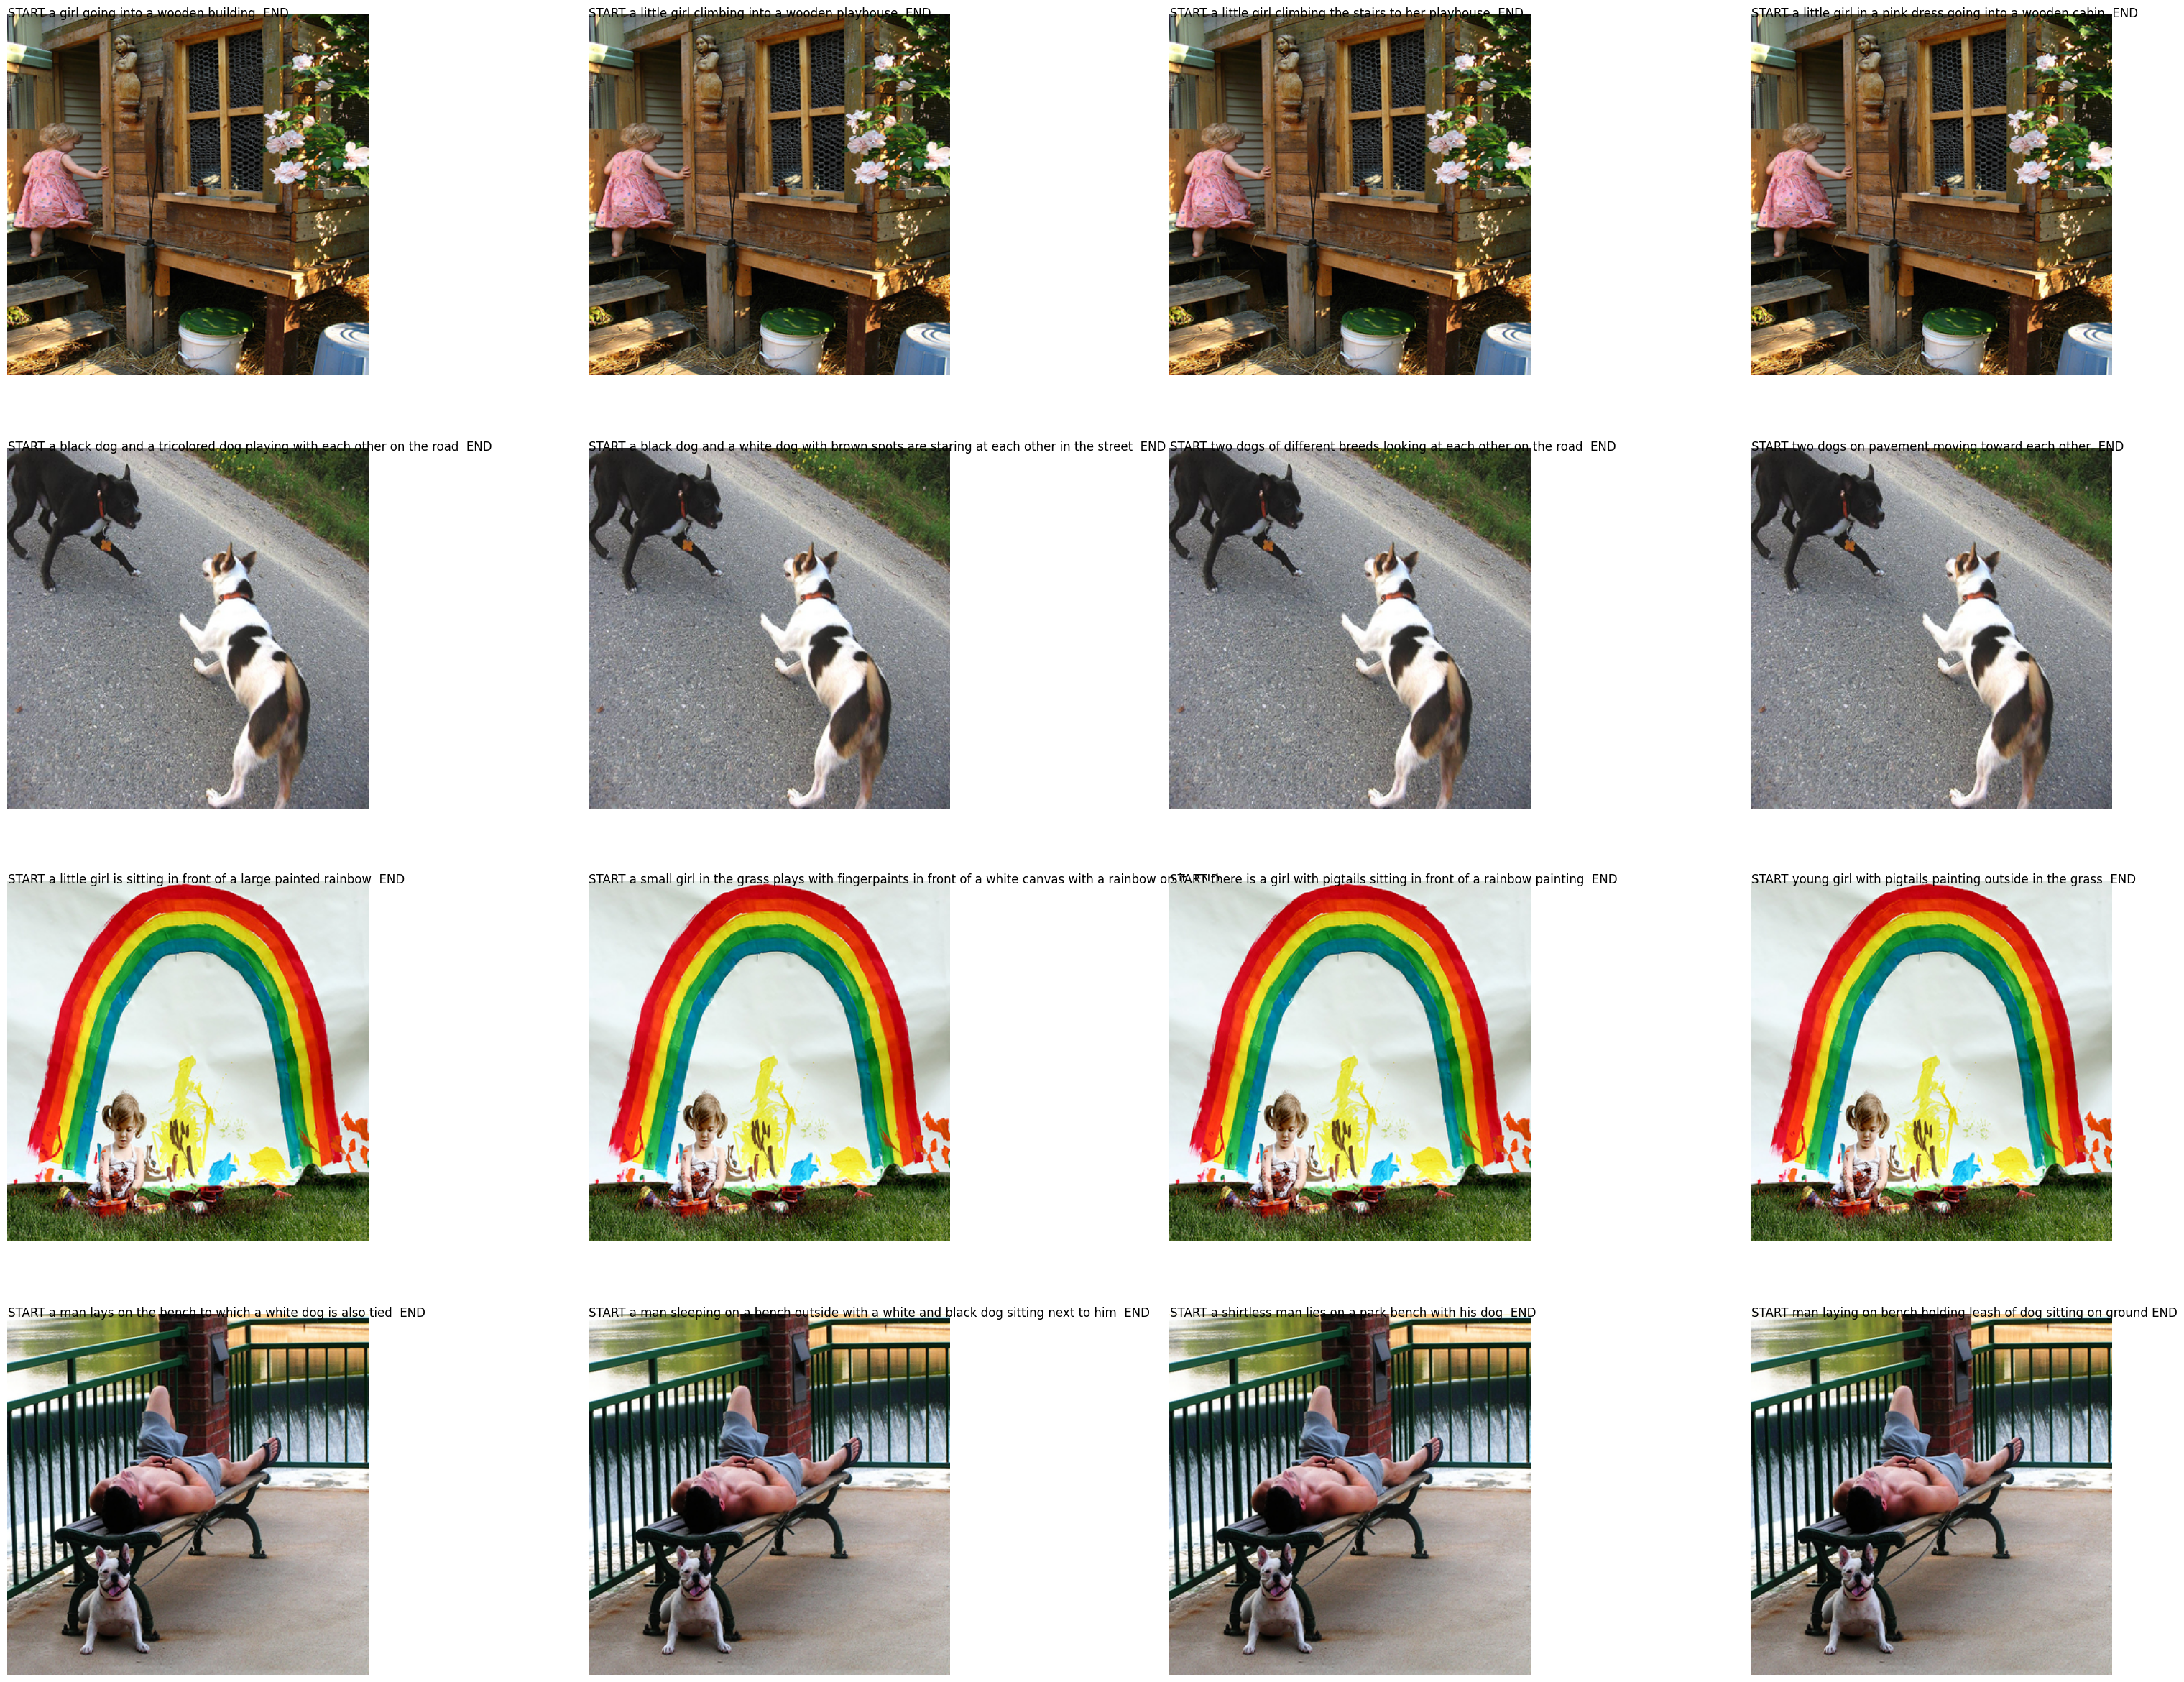

In [12]:
# Display fews images
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_data_train[i])
    plt.axis('off')
    # caption (small font size)
    plt.text(0, 2, text_data_train['caption'][i], fontsize=12)
    # largen plot size
    plt.gcf().set_size_inches(40, 30)
    
plt.show()

In [13]:
text_data_train_in = np.concatenate( (np.array(list(text_data_train['padded_sequences']))[:, :-1] , np.zeros((image_data_train.shape[0],1), dtype=np.int32) ), axis=1 )
text_data_train_out = np.concatenate( (np.array(list(text_data_train['padded_sequences']))[:, 1:] , np.zeros((image_data_train.shape[0],1), dtype=np.int32) ), axis=1 )
text_data_test_in = np.concatenate( (np.array(list(text_data_val['padded_sequences']))[:, :-1] , np.zeros((image_data_val.shape[0],1), dtype=np.int32)) , axis=1 )
text_data_test_out = np.concatenate( ( np.array(list(text_data_val['padded_sequences']))[:, 1:] , np.zeros((image_data_val.shape[0],1), dtype=np.int32)) , axis=1 )

image_data_train.shape, image_data_val.shape, text_data_train_in.shape, text_data_train_out.shape, text_data_test_in.shape, text_data_test_out.shape

((32364, 350, 350, 3),
 (8091, 350, 350, 3),
 (32364, 38),
 (32364, 38),
 (8091, 38),
 (8091, 38))

# Training Model

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, InputLayer, Embedding, LSTM, GRU, TimeDistributed, RepeatVector, Dense, Bidirectional, Flatten, LayerNormalization, Add, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50

In [15]:
batch_size =  8 * tpu_strategy.num_replicas_in_sync # 16
epochs = 200
# steps_per_execution = 32

In [16]:
# Loss Function # Masked Sparse Categorical Cross Entropy
def masked_categorical_cross_entropy( y_true, y_pred ):
    # Calculate the loss for each item in the batch.
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

# Accuracy Metric
def masked_accuracy(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [17]:
# Creating the model
channels = 3
units = 2048

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():

    ######  Image Encoder
    class Image_Encoder(tf.keras.layers.Layer):
        def __init__( self, input_shape, units, image_model=MobileNetV2, trainable=True ):
            super(Image_Encoder,self).__init__()
            self.input_image_shape = input_shape
            self.image_model = image_model(include_top=False, weights='imagenet', input_shape=self.input_image_shape)
            self.trainable = trainable
            self.units = units
            self.dense = Dense(units, activation='relu')

        def call( self, image_encoder_inputs ):
            image_features = self.image_model(image_encoder_inputs)
            # Flatten
            image_features = tf.keras.layers.Reshape((image_features.shape[1]*image_features.shape[2], image_features.shape[3]))( image_features )
            # Dense   # ********** #
            image_features = self.dense(image_features) # ********** #
            return image_features

        def get_config(self):
            config = super(Image_Encoder,self).get_config()
            config.update({ 'input_image_shape': self.input_image_shape, 'image_model': self.image_model, 'units': self.units, 'dense': self.dense, "trainable":self.trainable })
            return config

    class Decoder(tf.keras.layers.Layer):
        def __init__(self, vocab_size, units, max_length):
            super(Decoder,self).__init__()
            self.vocab_size = vocab_size
            self.units = units
            self.max_length = max_length
            self.Embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=self.units, input_length=self.max_length , mask_zero=True)
            self.gru_layer = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True)
            self.attention_layer = tf.keras.layers.Attention()
            self.add = Add()
            self.layernorm = LayerNormalization(axis=-1)
            self.dense = tf.keras.layers.Dense(vocab_size)

        def call( self, text_encoder_inputs, image_features ):
            # Embedding
            length = self.max_length
            encoder = self.Embedding
            encoder_embedding = encoder(text_encoder_inputs)
            # RNN
            gru_output, gru_state = self.gru_layer(encoder_embedding)
            # Attention
            # key & query --> gru_output | value --> encoder_output
            context_vector = self.attention_layer([gru_output, image_features])
            addition = self.add([gru_output,context_vector])
            norm_layer = self.layernorm(addition)
            # Dense
            output = self.dense(norm_layer) # overall_decoder_attention_output
            return output, gru_state

        def get_config(self):
            config = super(Decoder,self).get_config()
            config.update({ 'vocab_size': self.vocab_size, 'units': self.units, 'max_length': self.max_length, 'Embedding': self.Embedding, "gru_layer":self.gru_layer,
                             'attention_layer':self.attention_layer, 'add':self.add, 'layernorm':self.layernorm, "dense":self.dense })
            return config


    # Inputs
    text_encoder_inputs = Input(shape=(max_length,))
    image_encoder_inputs = Input(shape=(image_height, image_width, channels))

    # Image Encoding
    image_encoder = Image_Encoder( input_shape=(image_height, image_width, channels), image_model=ResNet50, units=units, trainable=True )
    image_features = image_encoder( image_encoder_inputs )

    # Decoding Caption
    decoder = Decoder(vocab_size=vocab_size, units=units, max_length=max_length)
    output, gru_state = decoder( text_encoder_inputs, image_features )

    # Model
    training_model = tf.keras.Model(inputs=[image_encoder_inputs,text_encoder_inputs], outputs=output)   

    # Compile
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay( initial_learning_rate=1e-4, decay_steps=1000)
    training_model.compile(loss=masked_categorical_cross_entropy, optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_decayed_fn),metrics=[masked_accuracy]) # Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
    training_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 image__encoder (Image_Encoder)  (None, 121, 2048)   27784064    ['input_2[0][0]']                
                                                                                                  
 decoder (Decoder)           

In [18]:
# early_stopping = EarlyStopping(monitor='loss', patience=20)
checkpoint = ModelCheckpoint("Image_Captioning_Transfomer_Model", moniter='loss',save_best_only=True, save_weights_only=False, mode='min')
# reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=2, min_lr=1e-10,mode="min")
history = training_model.fit( [image_data_train,text_data_train_in], text_data_train_out, validation_data=([image_data_val,text_data_test_in],text_data_test_out), 
                                 epochs=epochs, batch_size=batch_size, callbacks=[checkpoint] )

Epoch 1/200


2023-06-28 15:05:31.884799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-28 15:05:32.924535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


506/506 [==============================] - ETA: 0s - loss: 4.1662 - masked_accuracy: 0.2916

2023-06-28 15:08:18.673262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-28 15:08:19.021998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


506/506 [==============================] - 293s 424ms/step - loss: 4.1662 - masked_accuracy: 0.2916 - val_loss: 3.4230 - val_masked_accuracy: 0.3831
Epoch 2/200
506/506 [==============================] - ETA: 0s - loss: 3.2257 - masked_accuracy: 0.3827

INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


506/506 [==============================] - 150s 297ms/step - loss: 3.2257 - masked_accuracy: 0.3827 - val_loss: 3.2335 - val_masked_accuracy: 0.4007
Epoch 3/200
506/506 [==============================] - ETA: 0s - loss: 3.0701 - masked_accuracy: 0.4032

INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


506/506 [==============================] - 149s 295ms/step - loss: 3.0701 - masked_accuracy: 0.4032 - val_loss: 3.2335 - val_masked_accuracy: 0.4005
Epoch 4/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0704 - masked_accuracy: 0.4029 - val_loss: 3.2338 - val_masked_accuracy: 0.4006
Epoch 5/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0710 - masked_accuracy: 0.4026 - val_loss: 3.2336 - val_masked_accuracy: 0.4005
Epoch 6/200
506/506 [==============================] - 80s 159ms/step - loss: 3.0702 - masked_accuracy: 0.4028 - val_loss: 3.2338 - val_masked_accuracy: 0.4005
Epoch 7/200
506/506 [==============================] - 80s 159ms/step - loss: 3.0697 - masked_accuracy: 0.4025 - val_loss: 3.2339 - val_masked_accuracy: 0.4003
Epoch 8/200
506/506 [==============================] - 81s 159ms/step - loss: 3.0697 - masked_accuracy: 0.4023 - val_loss: 3.2336 - val_masked_accuracy: 0.4006
Epoch 9/200
506/506 [==============================

INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


506/506 [==============================] - 148s 293ms/step - loss: 3.0718 - masked_accuracy: 0.4026 - val_loss: 3.2333 - val_masked_accuracy: 0.4006
Epoch 10/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0709 - masked_accuracy: 0.4023 - val_loss: 3.2336 - val_masked_accuracy: 0.4004
Epoch 11/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0707 - masked_accuracy: 0.4023 - val_loss: 3.2337 - val_masked_accuracy: 0.4005
Epoch 12/200
506/506 [==============================] - 80s 159ms/step - loss: 3.0691 - masked_accuracy: 0.4029 - val_loss: 3.2336 - val_masked_accuracy: 0.4006
Epoch 13/200
506/506 [==============================] - 81s 159ms/step - loss: 3.0705 - masked_accuracy: 0.4026 - val_loss: 3.2336 - val_masked_accuracy: 0.4003
Epoch 14/200
506/506 [==============================] - 81s 159ms/step - loss: 3.0705 - masked_accuracy: 0.4029 - val_loss: 3.2335 - val_masked_accuracy: 0.4006
Epoch 15/200
506/506 [========================

INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


506/506 [==============================] - 147s 292ms/step - loss: 3.0703 - masked_accuracy: 0.4023 - val_loss: 3.2333 - val_masked_accuracy: 0.4008
Epoch 51/200
506/506 [==============================] - 80s 159ms/step - loss: 3.0704 - masked_accuracy: 0.4021 - val_loss: 3.2337 - val_masked_accuracy: 0.4009
Epoch 52/200
506/506 [==============================] - 81s 159ms/step - loss: 3.0687 - masked_accuracy: 0.4024 - val_loss: 3.2335 - val_masked_accuracy: 0.4005
Epoch 53/200
506/506 [==============================] - 81s 159ms/step - loss: 3.0710 - masked_accuracy: 0.4026 - val_loss: 3.2335 - val_masked_accuracy: 0.4003
Epoch 54/200
506/506 [==============================] - 80s 158ms/step - loss: 3.0708 - masked_accuracy: 0.4022 - val_loss: 3.2337 - val_masked_accuracy: 0.4007
Epoch 55/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0700 - masked_accuracy: 0.4026 - val_loss: 3.2336 - val_masked_accuracy: 0.4003
Epoch 56/200
506/506 [========================

INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


INFO:tensorflow:Assets written to: Image_Captioning_Transfomer_Model/assets


506/506 [==============================] - 148s 293ms/step - loss: 3.0699 - masked_accuracy: 0.4032 - val_loss: 3.2332 - val_masked_accuracy: 0.4006
Epoch 124/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0699 - masked_accuracy: 0.4030 - val_loss: 3.2336 - val_masked_accuracy: 0.4007
Epoch 125/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0695 - masked_accuracy: 0.4033 - val_loss: 3.2336 - val_masked_accuracy: 0.4005
Epoch 126/200
506/506 [==============================] - 80s 159ms/step - loss: 3.0708 - masked_accuracy: 0.4028 - val_loss: 3.2337 - val_masked_accuracy: 0.4003
Epoch 127/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0715 - masked_accuracy: 0.4026 - val_loss: 3.2337 - val_masked_accuracy: 0.4007
Epoch 128/200
506/506 [==============================] - 81s 160ms/step - loss: 3.0703 - masked_accuracy: 0.4023 - val_loss: 3.2339 - val_masked_accuracy: 0.4005
Epoch 129/200
506/506 [==================

# Setup for Inference

In [19]:
inference_model = tf.keras.Model(inputs=training_model.input, outputs=training_model.layers[3].output)
# output, gru_state = inference_model.predict( [ image_data_train[0:2], text_data_train_in[0:2]] )

Original Caption START a little girl is sitting in front of a large painted rainbow  END | START a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it  END | START there is a girl with pigtails sitting in front of a rainbow painting  END | START young girl with pigtails painting outside in the grass  END


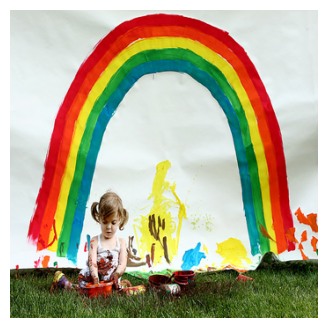

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']


In [20]:
def create_caption( image, model ):
    
    # Display fews images
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
        
    image = np.expand_dims(image, axis=0) 
    initial_token = tokenizer.texts_to_sequences(["START"])[0]
    initial_token += [0] * (max_length - len(initial_token))

    gru_state = np.zeros( (1,units) )
    tokens = np.expand_dims( np.array( initial_token ), axis=0 )
    
    for i in range(1,max_length):
        output, gru_state = model.predict( [image,tokens], verbose=0 )
        current_pred_token = np.argmax(output[:,-1,:],axis=-1)

        tokens[0][i] = current_pred_token

    pred_caption = tokenizer.sequences_to_texts( tokens )
    print( "Predicted Caption: ", pred_caption )
    
    return pred_caption

index = 10
print( "Original Caption", " | ".join(list(text_data_train[ text_data_train['image_name']==text_data_train['image_name'][index] ]['caption'].values)) )
pred_caption = create_caption( image=image_data_train[index], model=inference_model )

# Create Caption

Original Caption START a man drives a jeep over rough rocks  END | START a man driving a green jeep is crossing over large rocks  END | START a man is driving a green tractorlike vehicle over rocks  END | START a vehicle climbs on rocks near a forest  END


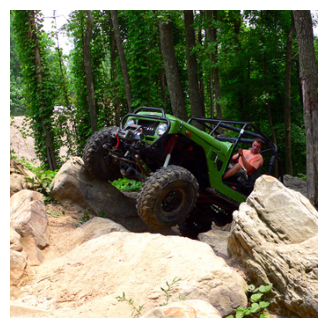

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START an elderly woman is looking at a teenage boy END | START a woman scratching her face  END | START there are two people  a lady with a big ring on her finger  and a boy wearing a blue jacket  END | START the woman in red clothing is wearing a ring and looking at a boy in blue clothing  END


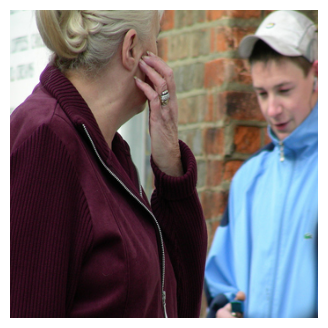

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START an old man wearing a red hat and black raincoat  END | START an old man with white hair in a red hat END | START a person is a red hat and winter jacket is looking into the distance  END | START a person with gray hair wears a red hat and watches it snow  END


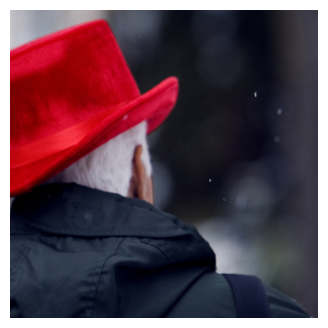

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a young boy playing basketball in a gym  wearing a uniform  END | START the boy in the royal blue basketball uniform is dribbling the ball down court  END | START the boy runs across the court with the basketballs  END | START the young boy is running while bouncing a basketball  END


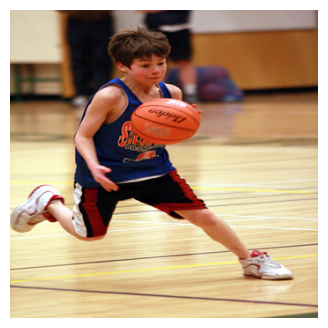

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START two boys hold their feet in their hands while balancing on one foot  END | START two boys in running clothes stretching  END | START two boys standing holding the ankle of one crossed leg  END | START two young man holding one leg in their hand END


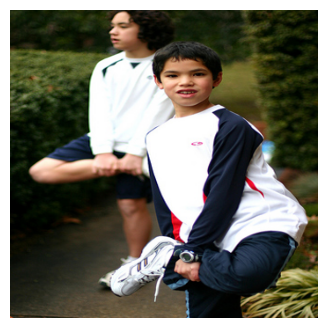

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a man in a black hat stands in front of a red wall  END | START a man wearing all black and a black hat is smiling  END | START a man with a hat  glasses  jewelry and a jacket stands against an orange wall  END | START there is a man with glasses and a hat wearing a black suit jacket indoors  END


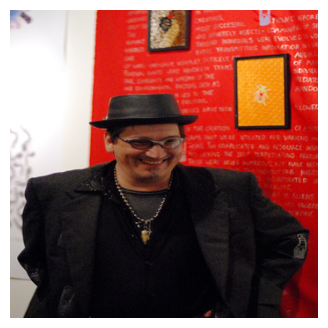

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a woman in a blue shirt in a crowd  END | START a woman in a blue shirt standing in a crowd of people  END | START a woman in a blue striped shirt with her hands on her hips in a crowd of people  END | START a woman wearing a shirt that has risen up from the waist of her jeans  END


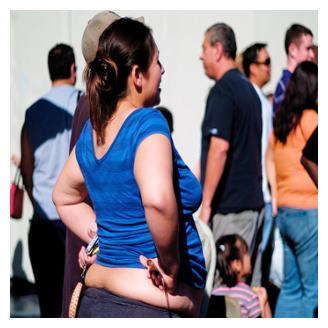

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START three boys in size order getting wet next to a wall END | START three boys play in a spray of water  END | START three boys playing in some water  END | START three shirtless boys are playing in the water  END


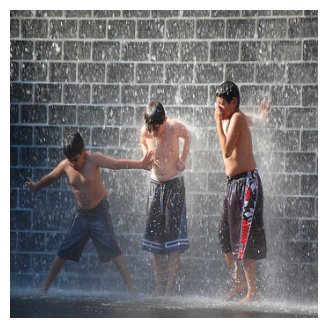

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a boy covered in suds has his face wiped clean  END | START a boy is covered in bubbles  END | START a child covered in foam is climbing on a black inflatable ramp  END | START a person covered in soapy water is getting cleaned off  END


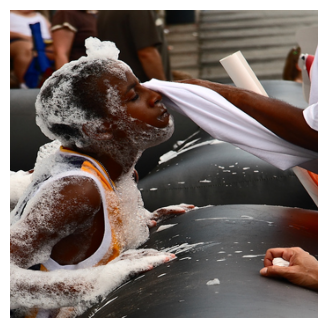

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START two children running in a field  END | START two children running in a field with a kite there is a fence in the background and mountains END | START two young girls fly a kite  END | START two young girls run across a field as they fly a kite in the cloudcovered sky  END


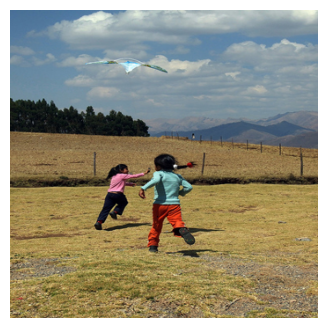

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a boy diving backward off a pier in a large lake  END | START a boy in a blue life jacket jumps into the water  END | START a boy in a blue life jacket jumps off a board into the lake  END | START a boy is holding his nose and jumping off a diving board backwards into a lake  END


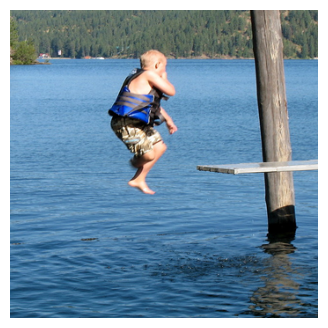

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a woman in an orange coat and jeans is squatting on a rock wall while a blonde woman in a red jacket stands next to her on the wall checking her electronic device END | START a woman in a red jacket standing on a rock next to a woman crouching on a rock  END | START many people are walking through a park with a lot of trees  END | START two women are on a rock wall while others walk along a path  END


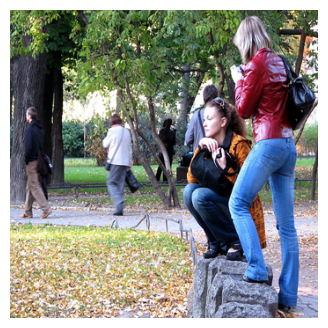

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START three dogs come face to face with each other in a snowy field  END | START three dogs in the snow  END | START three dogs meet in the snow  END | START three dogs playing in the snow  END


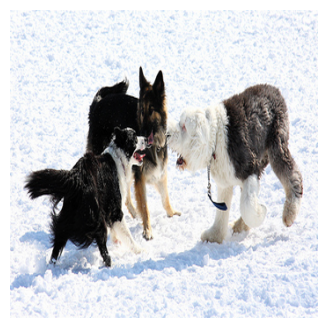

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a little girl in pink pajamas tries to operate a camera  END | START a little girl takes a picture while mom watches in boredom  END | START small girl in pink clothing holding a camera in her hands  END | START the girl in the pink sweater is playing with a camera whilst being watched by the woman on the couch END


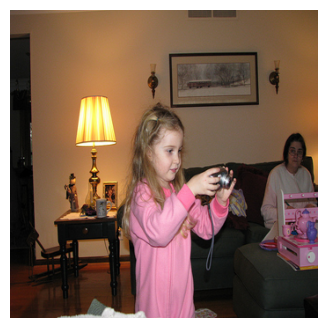

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a child plays in the mud  END | START a muddy child jumps into more mud on the ground  END | START a wet boy jumping around on dirty wet grass END | START young boy covered in grass jumping near a wooden fence  END


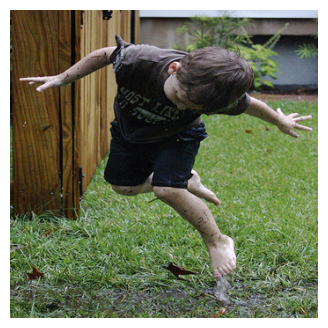

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a black and white dog is carrying a stick in its mouth  END | START a black and white dog walking through the grass with a long stick in his mouth  END | START a dog holds a stick in its mouth  END | START a dog trots across the ground with a large stick in his mouth  END


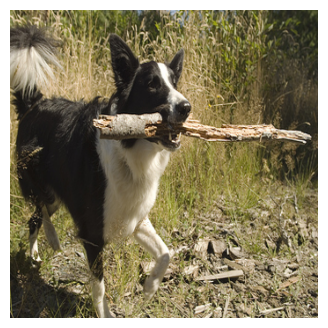

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a white dog catching a blue ball END | START a white dog jumps to catch a blue ball in a living room  END | START the dog is jumping in the air to catch a ball  END | START two dogs in a family room are playing  one is catching a ball in its mouth  END


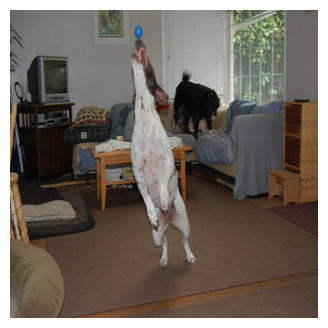

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START two dogs are playing in the snow next to a tree  END | START two dogs are playing with a tennis ball in snow near a tree  END | START two dogs play in the snow on the ground near a tree  with one on top of the other  END | START two dogs tussle in the snow over a tennis ball  END


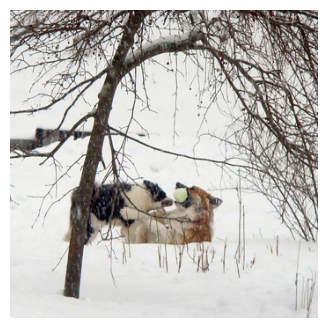

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a girl wearing a green and orange dress walks on the street with a balloon  END | START a little girl in an elaborate green and orange dress is chasing after a pink and white balloon figure  END | START a little girl on the street in a yellowish green and orange dress is holding a hello kitty balloon with her right hand  END | START the girl is wearing a green dress and holding a hello kitty balloon  END


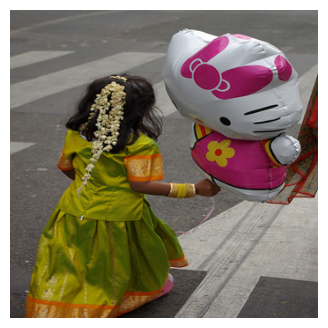

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 

Original Caption START a woman wearing a pink cap riding a bicycle END | START a woman wearing black clothes  a purple scarf  and a pink hat is riding a bike  END | START a woman with glasses and a pink hat rides her bike  END | START the woman is wearing a pink hat and is riding a bike in the park  END


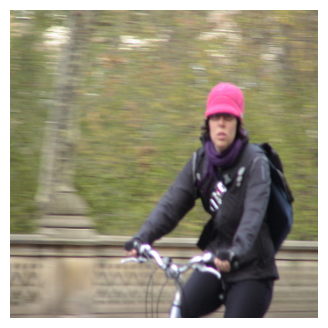

Predicted Caption:  ['START two men are playing with their in front of them END END END END END END END END END END END END END END END END END END END END END END END END END END END']
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



In [21]:
for index in np.random.randint(int(image_data_train.shape[0]/4 - 1),size=20):
    print( "Original Caption", " | ".join(list(text_data_train[ text_data_train['image_name']==text_data_train['image_name'][index] ]['caption'].values)) )
    pred_caption = create_caption( image=image_data_train[index], model=inference_model )
    print( "---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - \n \n" )

***